In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

plt.rc('axes', axisbelow=True)
%matplotlib inline

In [2]:
all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}
all_names_state = {j:i for i,j in all_state_names.items()}

In [3]:
df = pd.read_csv('../data/ihe_testing_casecounts_fall2020.csv', dtype={'ipeds_id':str})
ll = pd.read_csv('../data/county_level_data.csv', dtype={'fips':str})
ipeds_df = pd.read_csv('../data/ipeds_data.csv', encoding='latin8', dtype={'ipeds_id':str,
                                                                           'Fips County code (HD2019)':str})

rename_ipeds = {'Institution Name':'name', 'Latitude location of institution (HD2019)':'lat',
                'Longitude location of institution (HD2019)':'lon', 'Level of Institution':'institution_level',
                'Control of institution':'institution_control', 'Institution Size':'institution_size_bin',
                'Total enrollment (DRVEF2018)':'enrollment_total','Fips County code (HD2019)':'fips',
                'Full-time enrollment (DRVEF2018)':'enrollment_fulltime', 
                'Endowment per FTE':'endowment_per_fte',
                'Percent admitted - total (DRVADM2019)':'percent_admitted'}

ipeds_df = ipeds_df.rename(columns=rename_ipeds)
ipeds_df = ipeds_df[['ipeds_id','fips', 'lat', 'lon', 'institution_level', 'institution_control',
                     'institution_size_bin', 'enrollment_total', 'enrollment_fulltime',
                     'endowment_per_fte', 'percent_admitted']]
ipeds_df['fips'] = ("0"+ipeds_df['fips'].str[:]).str[-5:]
df = df.merge(ipeds_df[['ipeds_id','fips','enrollment_fulltime','enrollment_total']], how='left', on='ipeds_id')

In [4]:
# get counties of schools that do / don't test frequently

In [5]:
ihe_df = df.groupby(['college','ipeds_id','fips',
                     'enrollment_fulltime','enrollment_total']).agg({'total_tests':'sum',
                                                                     'positive_tests':'sum'}).reset_index()

In [6]:
cumul_only = df.loc[~df['notes'].isna()].reset_index().iloc[:,1:].copy()
cumul_tests = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_tests')].reset_index().iloc[:,1:].copy()
cumul_cases = cumul_only.loc[cumul_only['notes'].str.contains('cumulative_cases')].reset_index().iloc[:,1:].copy()
cumul_cases['positive_tests'] = [int(i[1]) for i in cumul_cases['notes'].str.split('cumulative_cases = ')]
cumul_tests['total_tests'] = [int(i[1]) for i in cumul_tests['notes'].str.split('cumulative_tests = ')]
# cumul_ipeds = np.unique(cumul_cases['ipeds_id'].to_list())
df_temp = df.copy()
df_temp['gran'] = df_temp['total_tests'] + df_temp['positive_tests']
df_temp = df_temp.groupby(['college','ipeds_id']).agg({'gran':'sum'}).reset_index()
cumul_ipeds = df_temp.loc[df_temp['gran']<=0]['ipeds_id'].values
# cumul_ipeds = np.unique(cumul_tests['ipeds_id'].to_list() + cumul_cases['ipeds_id'].to_list())

In [7]:
times_df = ihe_df.loc[~ihe_df['ipeds_id'].isin(cumul_ipeds)].reset_index().iloc[:,1:].copy()
cumul_df = df.loc[df['ipeds_id'].isin(cumul_ipeds)][['college', 'ipeds_id', 'fips',
                  'enrollment_fulltime','enrollment_total']].drop_duplicates().reset_index().iloc[:,1:].copy()
cumul_df = cumul_df.merge(cumul_tests[['ipeds_id','total_tests']],how='left',on='ipeds_id')
cumul_df = cumul_df.merge(cumul_cases[['ipeds_id','positive_tests']],how='left',on='ipeds_id')

dfw = pd.concat([times_df,cumul_df]).reset_index().iloc[:,1:].copy()
dfw['total_tests'] = np.nan_to_num(dfw['total_tests'])

In [8]:
dfw['total_tests_per_1000_fulltime'] = (dfw['total_tests']/dfw['enrollment_fulltime']) * 1000
dfw['total_tests_per_1000_enrollment'] = (dfw['total_tests']/dfw['enrollment_total']) * 1000
dfw['positive_tests_per_1000_fulltime'] = (dfw['positive_tests']/dfw['enrollment_fulltime']) * 1000
dfw['positive_tests_per_1000_enrollment'] = (dfw['positive_tests']/dfw['enrollment_total']) * 1000

In [9]:
min_tests = 1000
var = 'total_tests'
nontest_fips = list(dfw.loc[dfw[var]<=min_tests]['fips'].unique())
yestest_fips = list(dfw.loc[dfw[var]>min_tests]['fips'].unique())
nontest_fips = [i for i in nontest_fips if i not in yestest_fips]

ll_non = ll.loc[ll['fips'].isin(nontest_fips)].reset_index().iloc[:,1:].copy()
ll_yes = ll.loc[ll['fips'].isin(yestest_fips)].reset_index().iloc[:,1:].copy()

ll_non = ll_non.loc[(ll_non['date']>'2020-06-30')&(ll_non['date']<'2020-12-20')].copy()
ll_yes = ll_yes.loc[(ll_yes['date']>'2020-06-30')&(ll_yes['date']<'2020-12-20')].copy()

# To get local and state policies, I use data from:
https://www.covid-local.org/amp/

... but it needs some mangling in order to get it to match the spatial scale of counties...

In [10]:
county_shp = gpd.read_file('../../universities/data/tl_2017_us_county/')
dat_shp = county_shp.rename(columns={'GEOID':'fips'})
dat_shp.crs = {"init": "epsg:4326"}

xx = pd.read_csv('../data/local_policies_unique.csv')
geo_df = gpd.GeoDataFrame(xx, geometry=gpd.points_from_xy(xx.Longitude, xx.Latitude))
geo_df = geo_df.reset_index().iloc[:,1:]
geo_df.crs = {"init": "epsg:4326"}
geo_df = geo_df[['state','local_area','county','geometry']].copy()
sta_df = geo_df.loc[geo_df['county']!=1].copy().reset_index().iloc[:,1:]
geo_df = geo_df.loc[geo_df['county']==1].copy().reset_index().iloc[:,1:]
geo_df = gpd.sjoin(geo_df, dat_shp[['fips','geometry']], how="inner", op="within")
sta_df['fips'] = ['19','25','49']

out_geo = pd.concat([geo_df[['state','local_area','fips']],sta_df[['state','local_area','fips']]])
out_geo = out_geo.reset_index().iloc[:,1:]

/Users/brennan/anaconda3/envs/covid/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
local_policies = pd.read_csv('../data/local_policies.csv')
local_policies = local_policies.merge(out_geo, how='left', on=['state','local_area'])
local_policies = local_policies.loc[local_policies['date_end']>'2020-12-01'].copy().reset_index().iloc[:,1:]

In [12]:
local_policies.tail()

,location_resolution,state,local_area,relaxing_or_restricting,policy_category,policy_subcategory,policy_subtarget,policy_description,date_issued,date_start,date_end_anticipated,date_end,intended_duration,fips
1591,Local,Washington,"Seattle (city), WA",Other,Contact tracing/Testing,Contact tracing,General population (inclusive),City Departments immediately are authorized to...,2020-11-20,2020-11-20,Unspecified,Unspecified,https://durkan.seattle.gov/2020/11/building-on...,53033
1592,Local,Washington,"Seattle (city), WA",Restricting,Social distancing,Private sector closures,General population (inclusive),Loading zones will be temporarily added to res...,2020-04-06,2020-04-06,Unspecified,Unspecified,NaN,53033
1593,Local,Washington,"Seattle (city), WA",Restricting,Social distancing,Public service closures,Government/public buildings,"Seattle Parks and Recreation facilities, such ...",2020-06-03,2020-06-03,Unspecified,Unspecified,NaN,53033
1594,Local,Washington,"Seattle (city), WA",Restricting,Social distancing,Adaptation and mitigation measures,Public sector/government employees,In-person access to all City departments' publ...,2020-12-15,2020-12-15,Unspecified,Unspecified,Until further notice,53033
1595,Local,West Virginia,"Monongalia County, WV",Restricting,Social distancing,Adaptation and mitigation measures,Restaurants/bars,Bars in Monongalia County are subject to parti...,2020-10-13,2020-10-13,Unspecified,Unspecified,NaN,54061


In [13]:
state_policies = pd.read_csv('../data/state_policies.csv')
state_policies['fips'] = [all_ids_state[all_names_state[i]] for i in state_policies['state']]
state_policies = state_policies.loc[(state_policies['date_end']>'2020-12-01')&\
                                    (state_policies['date_issued']<'2020-10-15')&\
                                    (state_policies['date_issued']>'2020-07-05')].copy().reset_index().iloc[:,1:]
state_policies = state_policies.loc[state_policies['relaxing_or_restricting']=='Restricting'
                                    ].copy().reset_index().iloc[:,1:]
state_policies = state_policies.loc[state_policies['policy_category']=='Social distancing'
                                   ].copy().reset_index().iloc[:,1:]

In [14]:
state_policies.tail()

,location_resolution,state,relaxing_or_restricting,policy_category,policy_subcategory,policy_subtarget,policy_description,date_issued,date_start,date_end_anticipated,date_end,intended_duration,fips
199,state,Wyoming,Restricting,Social distancing,Adaptation and mitigation measures,General population (inclusive),Authorized gatherings of more than 50 people a...,2020-08-12,2020-08-16,2020-08-31,Unspecified,NaN,56
200,state,Wyoming,Restricting,Social distancing,Adaptation and mitigation measures,Entertainment/concert venues/nightclubs,"The operation of movie theaters, performance t...",2020-08-12,2020-08-16,2020-08-31,Unspecified,NaN,56
201,state,Wyoming,Restricting,Social distancing,Adaptation and mitigation measures,Gym/workout facility/fitness center,The operation of gymnasiums is subject to rest...,2020-08-12,2020-08-16,2020-08-31,Unspecified,NaN,56
202,state,Wyoming,Restricting,Social distancing,Adaptation and mitigation measures,Restaurants/bars,Restaurants and other places of public accommo...,2020-08-12,2020-08-16,2020-08-31,Unspecified,NaN,56
203,state,Wyoming,Restricting,Social distancing,Adaptation and mitigation measures,Childcare facilities (preschool or other daycare),The operation of child care centers or home da...,2020-08-12,2020-08-16,2020-08-31,Unspecified,NaN,56


In [15]:
# policy specifications: we want social distancing policies that are not ubiquitious
genpop = ['Other forms of social distancing',
          'Adaptation and mitigation measures',
          'Mass gathering restrictions',
          'Private sector closures',
          'Safer at home',
          'Distancing mandate',
          'Stay at home']

xtse = state_policies.loc[(state_policies['policy_subcategory'].isin(genpop))].fips.unique()

In [16]:
ll['state_fips'] = [i[:2] for i in ll['fips']]

In [17]:
yes_res_state = ll.loc[(ll['state_fips'].isin(xtse))&(ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()
non_res_state = ll.loc[(~ll['state_fips'].isin(xtse))&(ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()

In [18]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats

In [19]:
ci = '95'
non_res_stats_cases = get_ci(non_res_state,'new_cases_per_1000_county',percentile=ci).reset_index()
non_res_stats_death = get_ci(non_res_state,'new_deaths_per_1000_county',percentile=ci).reset_index()

yes_res_stats_cases = get_ci(yes_res_state,'new_cases_per_1000_county',percentile=ci).reset_index()
yes_res_stats_death = get_ci(yes_res_state,'new_deaths_per_1000_county',percentile=ci).reset_index()

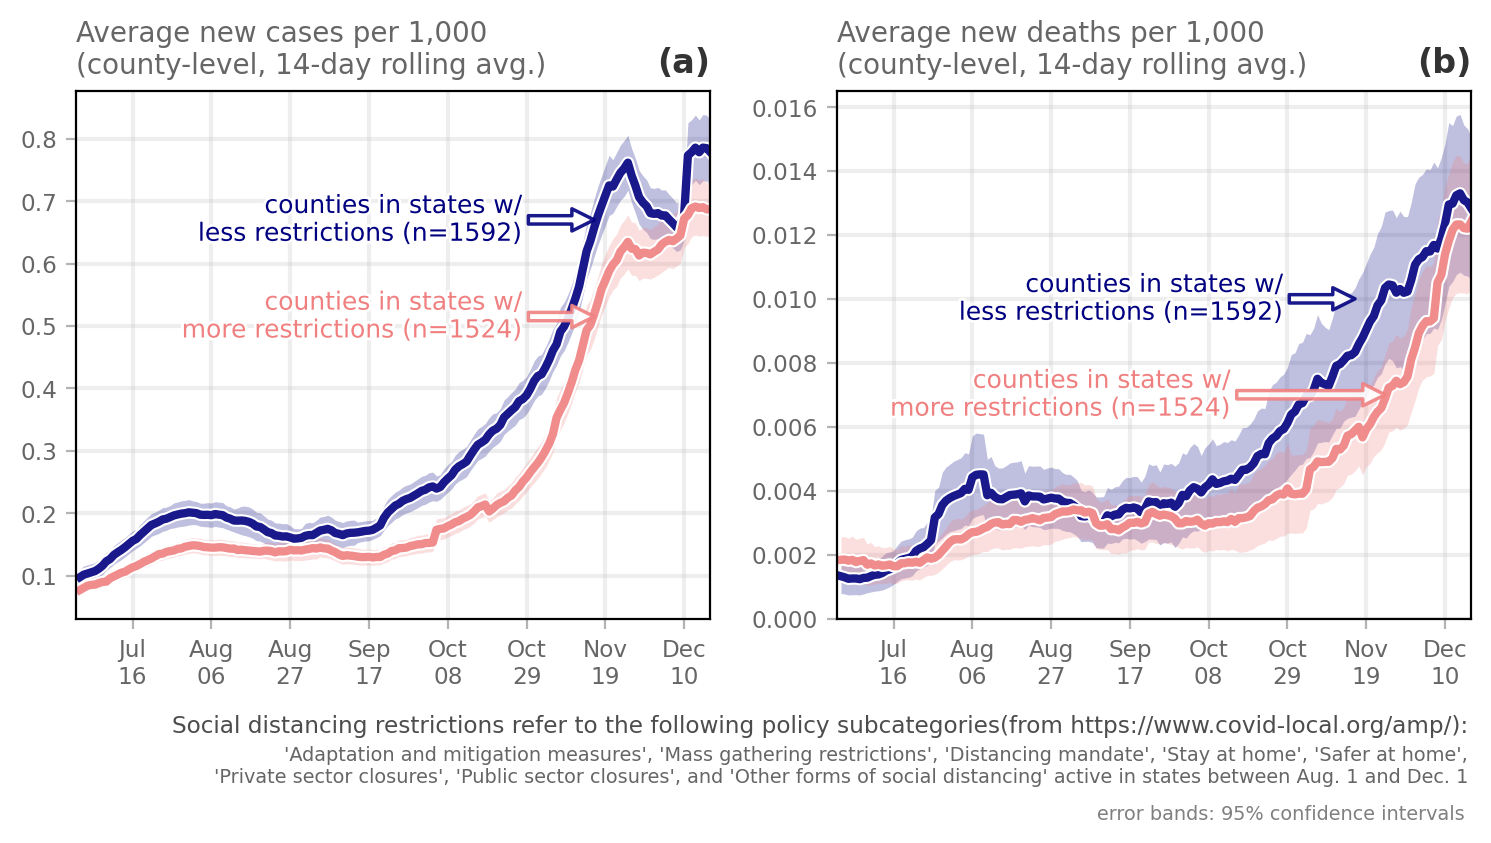

In [20]:
lw = 3
cols = ['navy','lightcoral','navy','lightcoral']
sta = ['counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions']
arrowlabs = ['counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions']
arrowxs = [(-32,-51),(-32,-51),(-32,-51),(-24,-65)]
arrowys = [0.67,0.515,0.01,0.007]

datalist = [non_res_stats_cases, yes_res_stats_cases, non_res_stats_death, yes_res_stats_death]
axlist = [0,0,1,1]

wid = 14

fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)

for di, dat_i in enumerate(datalist):

    x_vals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dat_i['date'].values]
    ax[axlist[di]].plot(x_vals, dat_i['nanmean'].rolling(window=wid).mean().values, 
                        color=cols[di],lw=lw,label=sta[di]+' $(n=%i)$'%np.mean(dat_i['count']),
                        alpha=0.9, path_effects=[path_effects.Stroke(linewidth=lw*1.5, foreground='w'),
                                                 path_effects.Normal()])

    ax[axlist[di]].fill_between(x_vals, dat_i['ci95_lo'].rolling(window=wid).mean().values,
                                dat_i['ci95_hi'].rolling(window=wid).mean().values,
                                alpha=0.25, color=cols[di], lw=0)
    ax[axlist[di]].annotate(arrowlabs[di]+" (n=%i)"%dat_i['count'].mean(),
                            xy=(x_vals[arrowxs[di][0]], arrowys[di]),
                            xytext=(x_vals[arrowxs[di][1]], arrowys[di]), 
                            arrowprops=dict(fc='w', ec=cols[di], width=3, lw=1.25,
                                            headwidth=8, headlength=8, alpha=0.9),
                            ha='right',va='center',fontsize=9,color=cols[di],zorder=2,
                            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                                          path_effects.Normal()])


ax[0].set_title('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].set_title('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].text(0.99, -0.35, 'error bands: 95% confidence intervals', ha='right', va='top',
           transform=ax[1].transAxes, color='.5', fontsize='x-small')
lab_i = "Social distancing restrictions refer to the following policy subcategories"+\
        "(from https://www.covid-local.org/amp/):"
lab_ix = "'Adaptation and mitigation measures', 'Mass gathering restrictions', "+\
         "'Distancing mandate', 'Stay at home', 'Safer at home',\n"+\
         "'Private sector closures', 'Public sector closures', and 'Other forms of social distancing' "+\
         "active in states between Aug. 1 and Dec. 1"

ax[1].text(0.995, -.18, lab_i, transform=ax[1].transAxes,
        color='.3',fontsize='small', ha='right', va='top')
ax[1].text(0.995, -.24, lab_ix, transform=ax[1].transAxes,
        color='.4',fontsize='x-small', ha='right', va='top')

letts = ["(a)","(b)"]
for ai,a in enumerate(fig.axes):
    a.set_xticks(x_vals[27::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_vals[27::21]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xlim(x_vals[12],x_vals[-1])

    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')


plt.savefig('../figs/pngs/county_statewide_policies_casedeaths.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/county_statewide_policies_casedeaths.pdf',bbox_inches='tight')

plt.show()

In [21]:
yestest_fips_yesstate = [i for i in yestest_fips if i[:2] in xtse]
yestest_fips_nonstate = [i for i in yestest_fips if i[:2] not in xtse]
print("%i yes-testing schools in yes-restriction counties ---"%len(yestest_fips_yesstate),
      "%i yes-testing schools in non-restriction counties"%len(yestest_fips_nonstate))

nontest_fips_yesstate = [i for i in nontest_fips if i[:2] in xtse]
nontest_fips_nonstate = [i for i in nontest_fips if i[:2] not in xtse]
print("%i non-testing schools in yes-restriction counties ---"%len(nontest_fips_yesstate),
      "%i non-testing schools in non-restriction counties"%len(nontest_fips_nonstate))

113 yes-testing schools in yes-restriction counties --- 131 yes-testing schools in non-restriction counties
126 non-testing schools in yes-restriction counties --- 142 non-testing schools in non-restriction counties


In [22]:
yestest_yesres_df = ll.loc[(ll['fips'].isin(yestest_fips_yesstate))&\
                           (ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()
yestest_nonres_df = ll.loc[(ll['fips'].isin(yestest_fips_nonstate))&\
                           (ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()

nontest_yesres_df = ll.loc[(ll['fips'].isin(nontest_fips_yesstate))&\
                           (ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()
nontest_nonres_df = ll.loc[(ll['fips'].isin(nontest_fips_nonstate))&\
                           (ll['date']<'2020-12-18')&(ll['date']>'2020-06-18')].copy()

In [23]:
ci = '90'
yestest_yesres_stats = get_ci(yestest_yesres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()
yestest_nonres_stats = get_ci(yestest_nonres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()

nontest_yesres_stats = get_ci(nontest_yesres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()
nontest_nonres_stats = get_ci(nontest_nonres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()

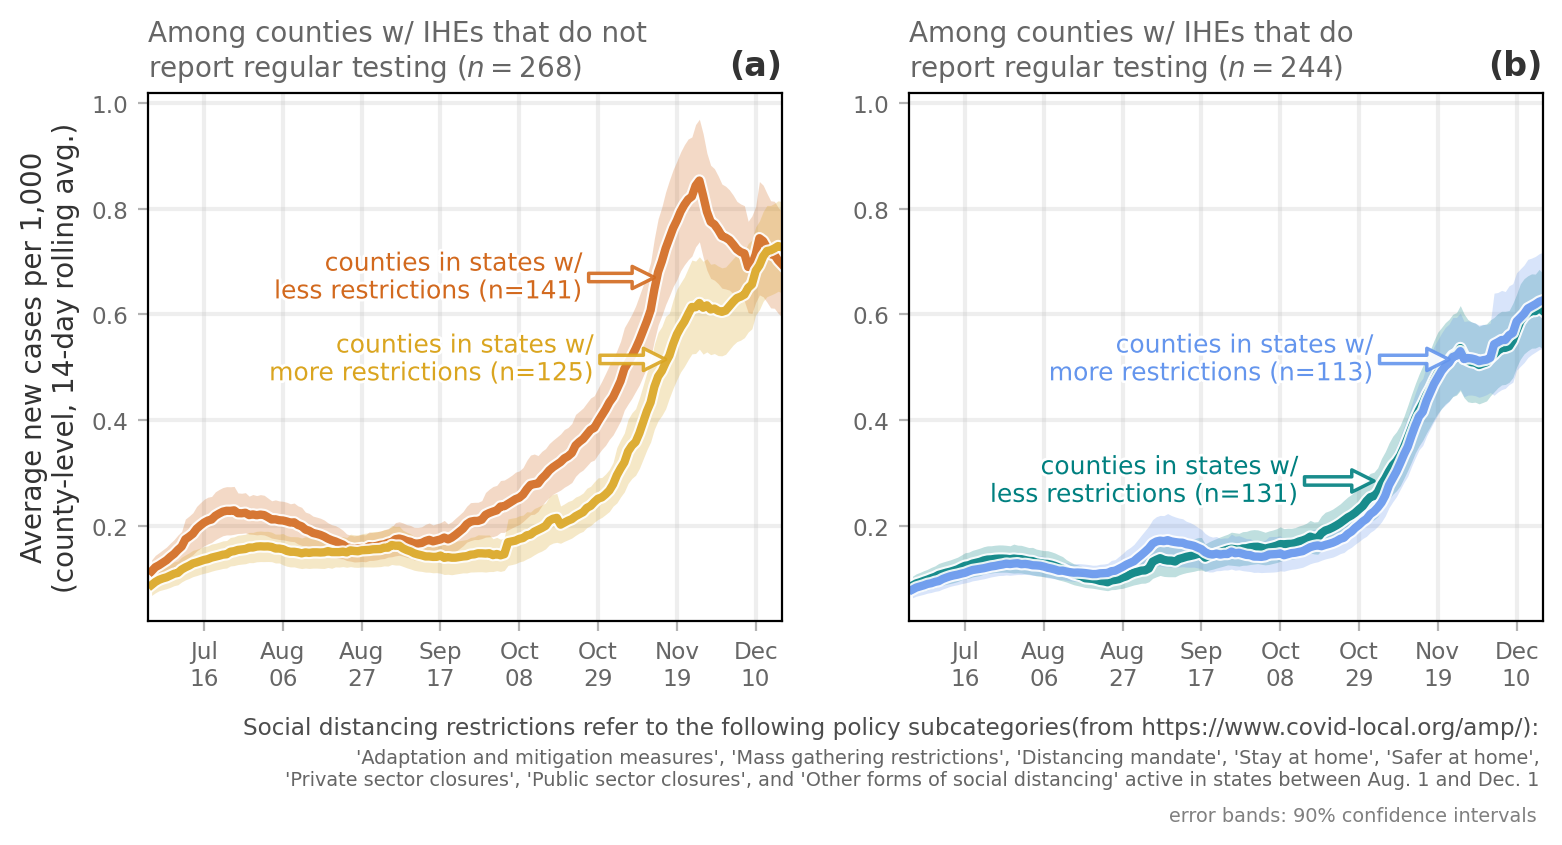

In [24]:
lw = 3
cols = ['chocolate','goldenrod','teal','cornflowerblue']
sta = ['counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions']
arrowlabs = ['counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions']
arrowxs = [(-35,-54),(-32,-51),(-46,-66),(-26,-46)]
arrowys = [0.67,0.515,0.285,0.515]

datalist = [nontest_nonres_stats, nontest_yesres_stats, yestest_nonres_stats, yestest_yesres_stats]
axlist = [0,0,1,1]

wid = 14

fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)

for di, dat_i in enumerate(datalist):

    x_vals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dat_i['date'].values]
    ax[axlist[di]].plot(x_vals, dat_i['nanmean'].rolling(window=wid).mean().values, 
                        color=cols[di],lw=lw,label=sta[di]+' $(n=%i)$'%np.mean(dat_i['count']),alpha=0.9,
                        path_effects=[path_effects.Stroke(linewidth=lw*1.5,alpha=0.9,foreground='w'),
                                      path_effects.Normal()])

    ax[axlist[di]].fill_between(x_vals, dat_i['ci95_lo'].rolling(window=wid).mean().values,
                                dat_i['ci95_hi'].rolling(window=wid).mean().values,
                                alpha=0.25, color=cols[di], lw=0)
    ax[axlist[di]].annotate(arrowlabs[di]+" (n=%i)"%dat_i['count'].mean(),
                            xy=(x_vals[arrowxs[di][0]], arrowys[di]),
                            xytext=(x_vals[arrowxs[di][1]], arrowys[di]), 
                            arrowprops=dict(fc='w', ec=cols[di], width=3, lw=1.25,
                                            headwidth=8, headlength=8, alpha=0.9),
                            ha='right',va='center',fontsize=9,color=cols[di],zorder=2,
                            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                                          path_effects.Normal()])

ax[0].set_ylabel('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[0].set_title('Among counties w/ IHEs that do not\nreport regular testing ($n=%i$)'%len(nontest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].set_title('Among counties w/ IHEs that do\nreport regular testing ($n=%i$)'%len(yestest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].text(0.99, -0.35, 'error bands: 90% confidence intervals', ha='right', va='top',
           transform=ax[1].transAxes, color='.5', fontsize='x-small')
lab_i = "Social distancing restrictions refer to the following policy subcategories"+\
        "(from https://www.covid-local.org/amp/):"
lab_ix = "'Adaptation and mitigation measures', 'Mass gathering restrictions', "+\
         "'Distancing mandate', 'Stay at home', 'Safer at home',\n"+\
         "'Private sector closures', 'Public sector closures', and 'Other forms of social distancing' "+\
         "active in states between Aug. 1 and Dec. 1"

ax[1].text(0.995, -.18, lab_i, transform=ax[1].transAxes,
        color='.3',fontsize='small', ha='right', va='top')
ax[1].text(0.995, -.24, lab_ix, transform=ax[1].transAxes,
        color='.4',fontsize='x-small', ha='right', va='top')

letts = ["(a)","(b)"]
for ai,a in enumerate(fig.axes):
    a.set_xticks(x_vals[27::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_vals[27::21]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xlim(x_vals[12],x_vals[-1])
    a.set_ylim(0.02, 1.02)

    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

plt.savefig('../figs/pngs/county_statewide_policies_campustesting_cases.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/county_statewide_policies_campustesting_cases.pdf',bbox_inches='tight')
plt.show()

In [25]:
ci = '90'
yestest_yesres_stats = get_ci(yestest_yesres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()
yestest_nonres_stats = get_ci(yestest_nonres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()

nontest_yesres_stats = get_ci(nontest_yesres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()
nontest_nonres_stats = get_ci(nontest_nonres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()

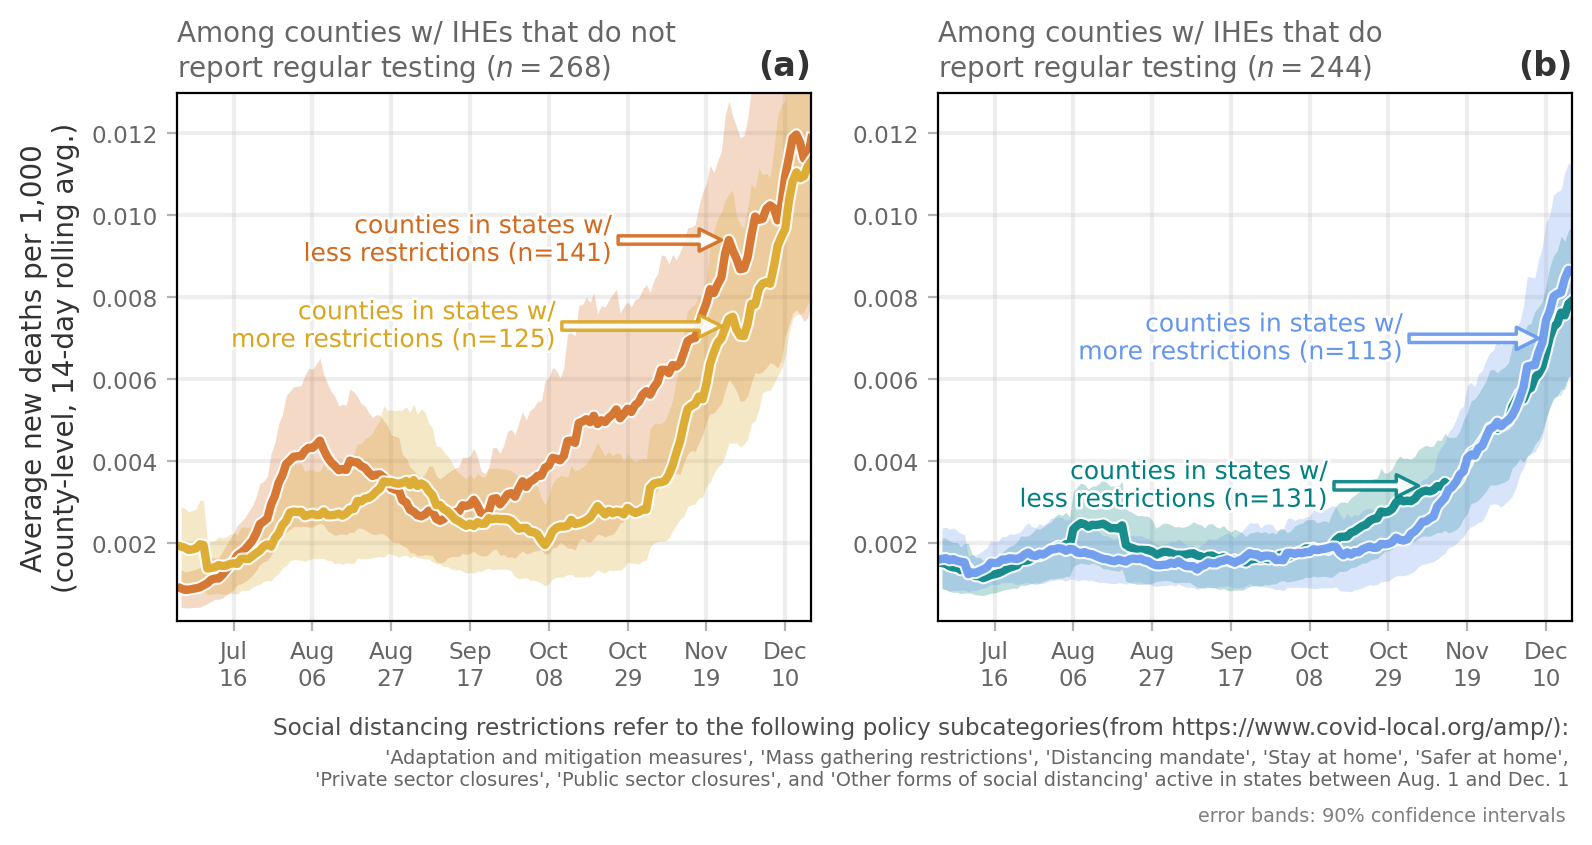

In [26]:
lw = 3
cols = ['chocolate','goldenrod','teal','cornflowerblue']
sta = ['counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions']
arrowlabs = ['counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions']
arrowxs = [(-25,-54),(-25,-69),(-42,-66),(-10,-46)]
arrowys = [0.0094,0.0073,0.0034,0.007]

datalist = [nontest_nonres_stats, nontest_yesres_stats, yestest_nonres_stats, yestest_yesres_stats]
axlist = [0,0,1,1]

wid = 14

fig, ax = plt.subplots(1,2,figsize=(9,3.5),dpi=200)

for di, dat_i in enumerate(datalist):

    x_vals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dat_i['date'].values]
    ax[axlist[di]].plot(x_vals, dat_i['nanmean'].rolling(window=wid).mean().values, 
                        color=cols[di],lw=lw,label=sta[di]+' $(n=%i)$'%np.mean(dat_i['count']),alpha=0.9,
                        path_effects=[path_effects.Stroke(linewidth=lw*1.5,alpha=0.9,foreground='w'),
                                      path_effects.Normal()])

    ax[axlist[di]].fill_between(x_vals, dat_i['ci95_lo'].rolling(window=wid).mean().values,
                                dat_i['ci95_hi'].rolling(window=wid).mean().values,
                                alpha=0.25, color=cols[di], lw=0)
    ax[axlist[di]].annotate(arrowlabs[di]+" (n=%i)"%dat_i['count'].mean(),
                            xy=(x_vals[arrowxs[di][0]], arrowys[di]),
                            xytext=(x_vals[arrowxs[di][1]], arrowys[di]), 
                            arrowprops=dict(fc='w', ec=cols[di], width=3, lw=1.25,
                                            headwidth=8, headlength=8, alpha=0.9),
                            ha='right',va='center',fontsize=9,color=cols[di],zorder=2,
                            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                                          path_effects.Normal()])

ax[0].set_ylabel('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[0].set_title('Among counties w/ IHEs that do not\nreport regular testing ($n=%i$)'%len(nontest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].set_title('Among counties w/ IHEs that do\nreport regular testing ($n=%i$)'%len(yestest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[1].text(0.99, -0.35, 'error bands: 90% confidence intervals', ha='right', va='top',
           transform=ax[1].transAxes, color='.5', fontsize='x-small')
lab_i = "Social distancing restrictions refer to the following policy subcategories"+\
        "(from https://www.covid-local.org/amp/):"
lab_ix = "'Adaptation and mitigation measures', 'Mass gathering restrictions', "+\
         "'Distancing mandate', 'Stay at home', 'Safer at home',\n"+\
         "'Private sector closures', 'Public sector closures', and 'Other forms of social distancing' "+\
         "active in states between Aug. 1 and Dec. 1"

ax[1].text(0.995, -.18, lab_i, transform=ax[1].transAxes,
        color='.3',fontsize='small', ha='right', va='top')
ax[1].text(0.995, -.24, lab_ix, transform=ax[1].transAxes,
        color='.4',fontsize='x-small', ha='right', va='top')

letts = ["(a)","(b)"]
for ai,a in enumerate(fig.axes):
    a.set_xticks(x_vals[27::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_vals[27::21]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xlim(x_vals[12],x_vals[-1])
    a.set_ylim(0.0001, 0.013)

    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

plt.savefig('../figs/pngs/county_statewide_policies_campustesting_deaths.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/county_statewide_policies_campustesting_deaths.pdf',bbox_inches='tight')
plt.show()

In [27]:
ci = '90'
yestest_yesres_stats_c = get_ci(yestest_yesres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()
yestest_nonres_stats_c = get_ci(yestest_nonres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()
nontest_yesres_stats_c = get_ci(nontest_yesres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()
nontest_nonres_stats_c = get_ci(nontest_nonres_df, 'new_cases_per_1000_county',percentile=ci).reset_index()

yestest_yesres_stats_d = get_ci(yestest_yesres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()
yestest_nonres_stats_d = get_ci(yestest_nonres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()
nontest_yesres_stats_d = get_ci(nontest_yesres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()
nontest_nonres_stats_d = get_ci(nontest_nonres_df, 'new_deaths_per_1000_county',percentile=ci).reset_index()

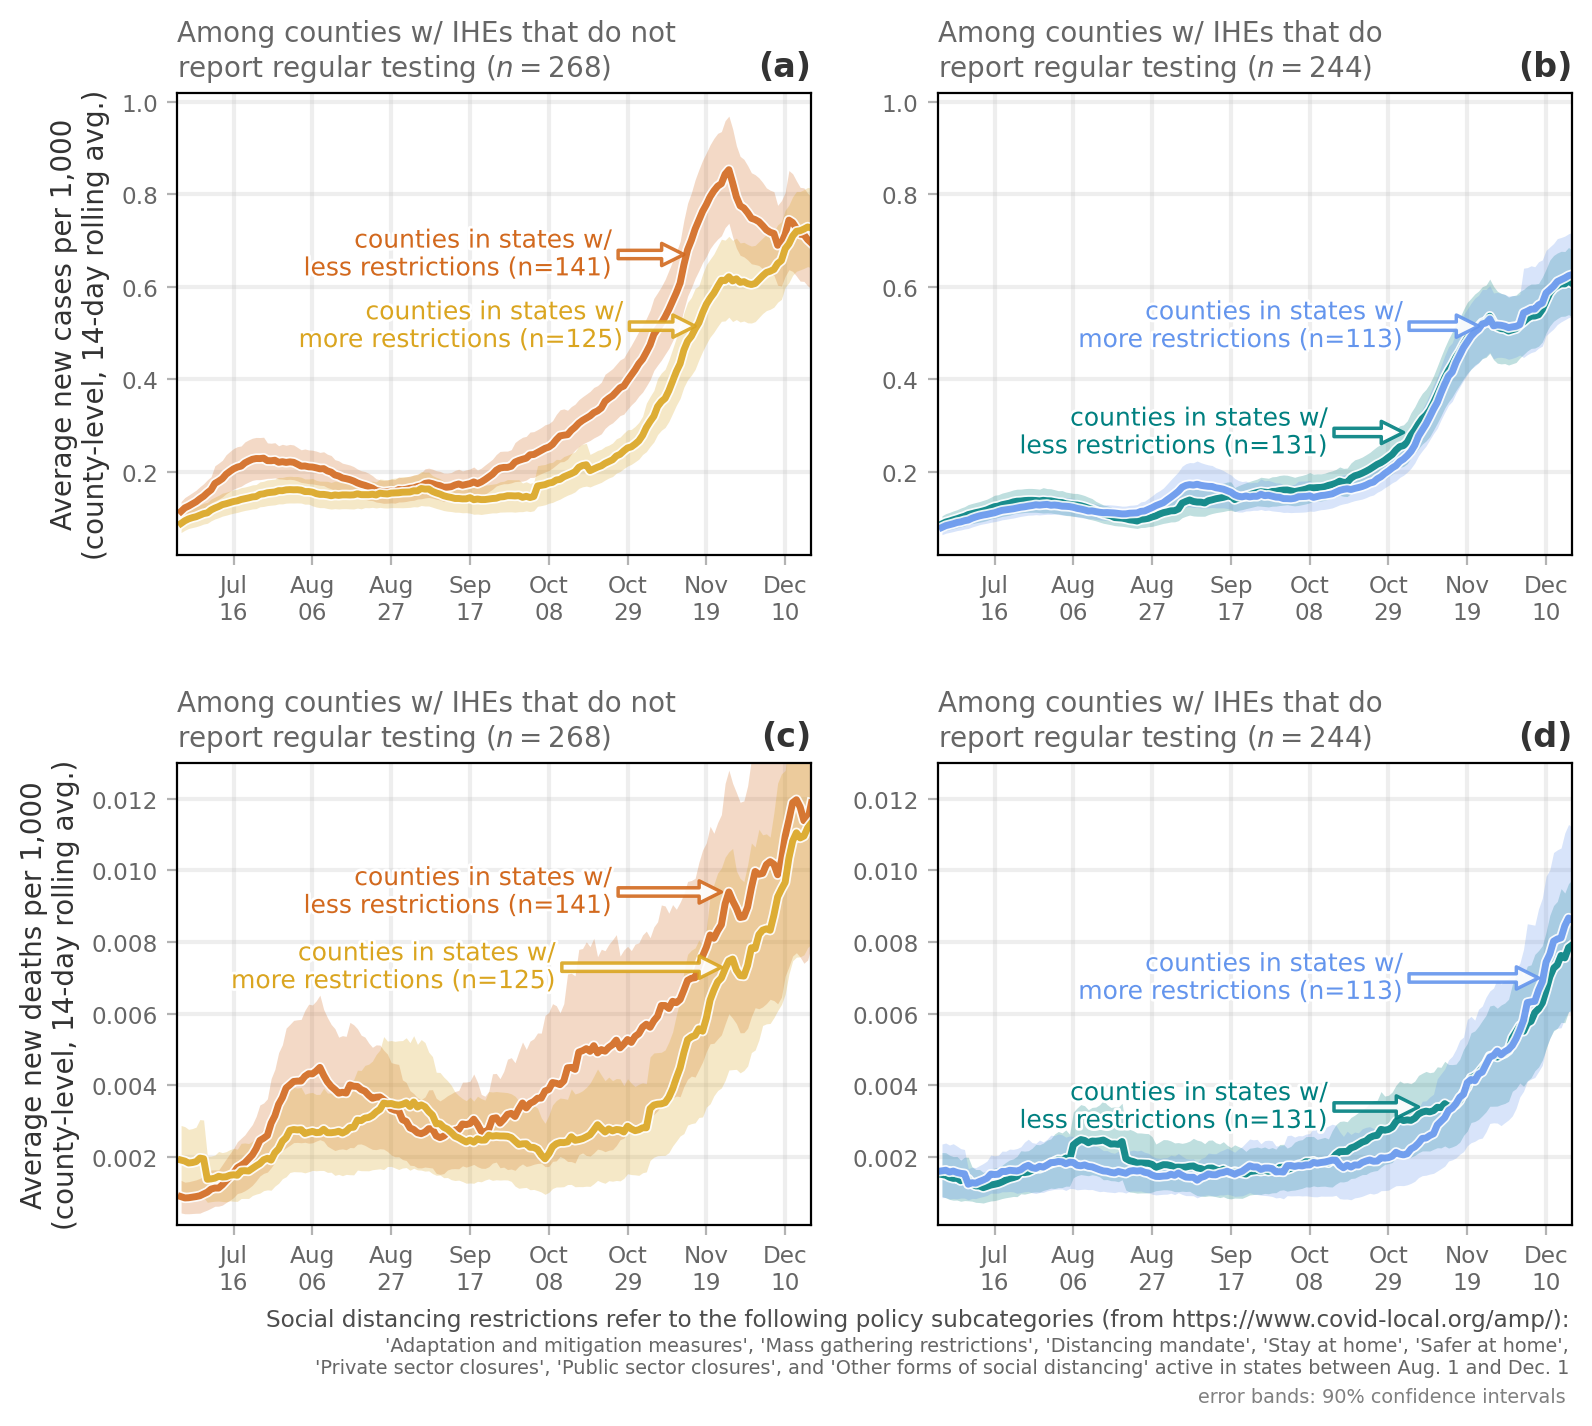

In [28]:
lw = 2.5
cols = ['chocolate','goldenrod','teal','cornflowerblue','chocolate','goldenrod','teal','cornflowerblue']
sta = ['counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions']
arrowlabs = ['counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions',
             'counties in states w/\nless restrictions', 'counties in states w/\nmore restrictions']
arrowxs = [(-35,-54),(-32,-51),(-46,-66),(-26,-46),(-25,-54),(-25,-69),(-42,-66),(-10,-46)]
arrowys = [0.67,0.515,0.285,0.515,0.0094,0.0073,0.0034,0.007]

datalist = [nontest_nonres_stats_c, nontest_yesres_stats_c, yestest_nonres_stats_c, yestest_yesres_stats_c,
            nontest_nonres_stats_d, nontest_yesres_stats_d, yestest_nonres_stats_d, yestest_yesres_stats_d]
axlist = [(0,0),(0,0),(0,1),(0,1),(1,0),(1,0),(1,1),(1,1)]

wid = 14

fig, ax = plt.subplots(2,2,figsize=(9,7.5),dpi=200)
plt.subplots_adjust(hspace=0.45,wspace=0.2)

for di, dat_i in enumerate(datalist):

    x_vals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dat_i['date'].values]
    ax[axlist[di]].plot(x_vals, dat_i['nanmean'].rolling(window=wid).mean().values, 
                        color=cols[di],lw=lw,label=sta[di]+' $(n=%i)$'%np.mean(dat_i['count']),alpha=0.9,
                        path_effects=[path_effects.Stroke(linewidth=lw*1.5,alpha=0.9,foreground='w'),
                                      path_effects.Normal()])

    ax[axlist[di]].fill_between(x_vals, dat_i['ci95_lo'].rolling(window=wid).mean().values,
                                dat_i['ci95_hi'].rolling(window=wid).mean().values,
                                alpha=0.25, color=cols[di], lw=0)
    ax[axlist[di]].annotate(arrowlabs[di]+" (n=%i)"%dat_i['count'].mean(),
                            xy=(x_vals[arrowxs[di][0]], arrowys[di]),
                            xytext=(x_vals[arrowxs[di][1]], arrowys[di]), 
                            arrowprops=dict(fc='w', ec=cols[di], width=3, lw=1.25,
                                            headwidth=8, headlength=8, alpha=0.9),
                            ha='right',va='center',fontsize=9,color=cols[di],zorder=2,
                            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                                          path_effects.Normal()])

ax[(0,0)].set_ylabel('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[(1,0)].set_ylabel('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[(0,0)].set_title('Among counties w/ IHEs that do not\nreport regular testing ($n=%i$)'%len(nontest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[(0,1)].set_title('Among counties w/ IHEs that do\nreport regular testing ($n=%i$)'%len(yestest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,0)].set_title('Among counties w/ IHEs that do not\nreport regular testing ($n=%i$)'%len(nontest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,1)].set_title('Among counties w/ IHEs that do\nreport regular testing ($n=%i$)'%len(yestest_fips),
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,1)].text(0.99, -0.35, 'error bands: 90% confidence intervals', ha='right', va='top',
           transform=ax[(1,1)].transAxes, color='.5', fontsize='x-small')
lab_i = "Social distancing restrictions refer to the following policy subcategories"+\
        " (from https://www.covid-local.org/amp/):"
lab_ix = "'Adaptation and mitigation measures', 'Mass gathering restrictions', "+\
         "'Distancing mandate', 'Stay at home', 'Safer at home',\n"+\
         "'Private sector closures', 'Public sector closures', and 'Other forms of social distancing' "+\
         "active in states between Aug. 1 and Dec. 1"

ax[(1,1)].text(0.995, -.18, lab_i, transform=ax[(1,1)].transAxes,
        color='.3',fontsize='small', ha='right', va='top')
ax[(1,1)].text(0.995, -.24, lab_ix, transform=ax[(1,1)].transAxes,
        color='.4',fontsize='x-small', ha='right', va='top')

letts = ["(a)","(b)","(c)","(d)"]
for ai,a in enumerate(fig.axes):
    a.set_xticks(x_vals[27::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_vals[27::21]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xlim(x_vals[12],x_vals[-1])
    if ai >= 2:
        a.set_ylim(0.0001, 0.013)
    else:
        a.set_ylim(0.02, 1.02)

    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

plt.savefig('../figs/pngs/county_statewide_policies_campustesting_casedeaths.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/county_statewide_policies_campustesting_casedeaths.pdf',bbox_inches='tight')
plt.show()

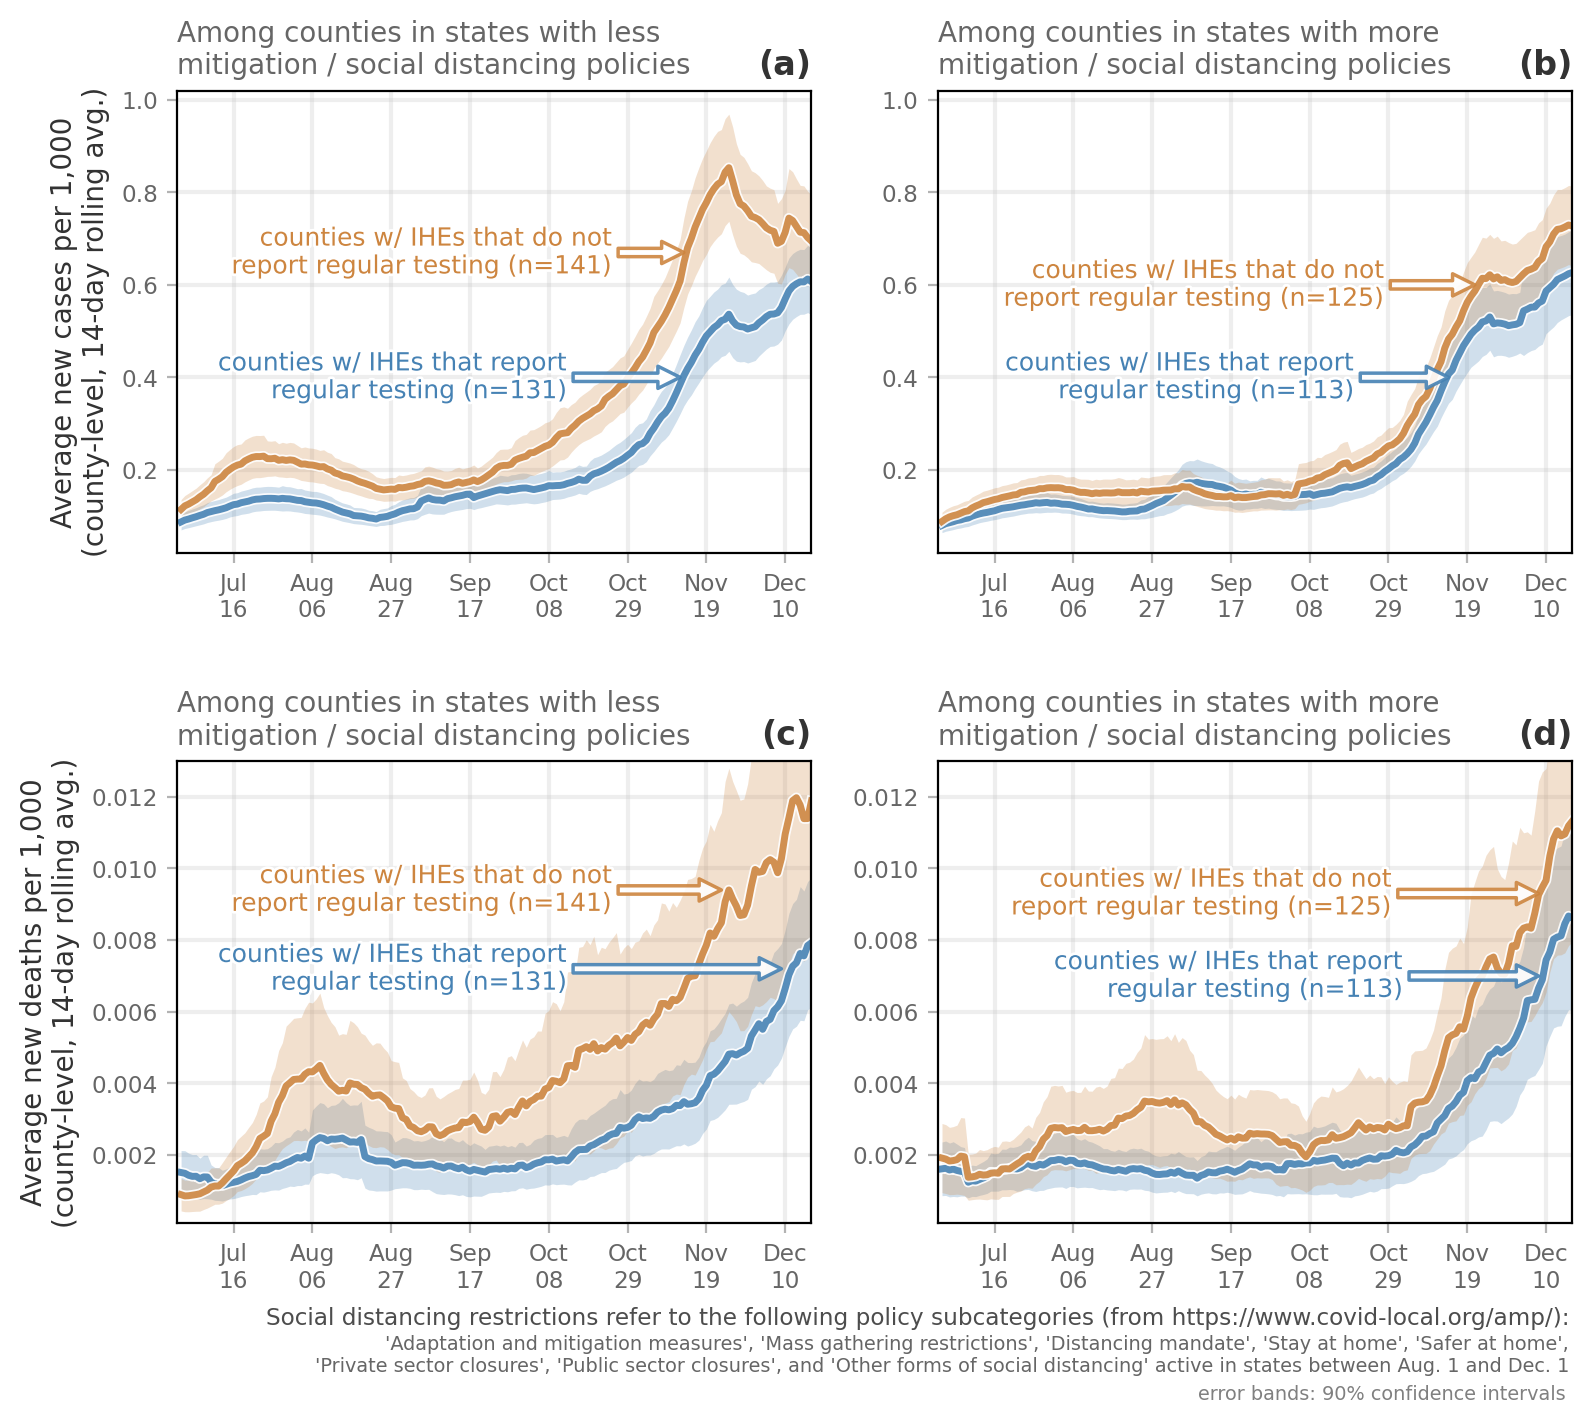

In [29]:
lw = 2.5
cols = ['steelblue','peru','steelblue','peru','steelblue','peru','steelblue','peru']
sta = ['counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions',
       'counties in states with less restrictions', 'counties in states with more restrictions']
arrowlabs = ['counties w/ IHEs that report\nregular testing', 
             'counties w/ IHEs that do not\nreport regular testing',
             'counties w/ IHEs that report\nregular testing', 
             'counties w/ IHEs that do not\nreport regular testing',
             'counties w/ IHEs that report\nregular testing', 
             'counties w/ IHEs that do not\nreport regular testing',
             'counties w/ IHEs that report\nregular testing', 
             'counties w/ IHEs that do not\nreport regular testing']

arrowxs = [(-36,-66),(-35,-54),(-34,-59),(-27,-51),(-9,-66),(-25,-54),(-10,-46),(-10,-49)]
arrowys = [0.4,0.67,0.40,0.6,0.0072,0.0094,0.007,0.0093]

datalist = [yestest_nonres_stats_c, nontest_nonres_stats_c, yestest_yesres_stats_c, nontest_yesres_stats_c,
            yestest_nonres_stats_d, nontest_nonres_stats_d, yestest_yesres_stats_d, nontest_yesres_stats_d]
axlist = [(0,0),(0,0),(0,1),(0,1),(1,0),(1,0),(1,1),(1,1)]

wid = 14

fig, ax = plt.subplots(2,2,figsize=(9,7.5),dpi=200)
plt.subplots_adjust(hspace=0.45,wspace=0.2)

for di, dat_i in enumerate(datalist):

    x_vals = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dat_i['date'].values]
    ax[axlist[di]].plot(x_vals, dat_i['nanmean'].rolling(window=wid).mean().values, 
                        color=cols[di],lw=lw,label=sta[di]+' $(n=%i)$'%np.mean(dat_i['count']),alpha=0.9,
                        path_effects=[path_effects.Stroke(linewidth=lw*1.5,alpha=0.9,foreground='w'),
                                      path_effects.Normal()])

    ax[axlist[di]].fill_between(x_vals, dat_i['ci95_lo'].rolling(window=wid).mean().values,
                                dat_i['ci95_hi'].rolling(window=wid).mean().values,
                                alpha=0.25, color=cols[di], lw=0)
    ax[axlist[di]].annotate(arrowlabs[di]+" (n=%i)"%dat_i['count'].mean(),
                            xy=(x_vals[arrowxs[di][0]], arrowys[di]),
                            xytext=(x_vals[arrowxs[di][1]], arrowys[di]), 
                            arrowprops=dict(fc='w', ec=cols[di], width=3, lw=1.25,
                                            headwidth=8, headlength=8, alpha=0.9),
                            ha='right',va='center',fontsize=9,color=cols[di],zorder=2,
                            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                                          path_effects.Normal()])

ax[(0,0)].set_ylabel('Average new cases per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[(1,0)].set_ylabel('Average new deaths per 1,000\n(county-level, %i-day rolling avg.)'%(wid),
                color='.2', fontsize='medium')
ax[(0,0)].set_title('Among counties in states with less\nmitigation / social distancing policies',
                color='.4',x=0,ha='left', fontsize='medium')
ax[(0,1)].set_title('Among counties in states with more\nmitigation / social distancing policies',
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,0)].set_title('Among counties in states with less\nmitigation / social distancing policies',
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,1)].set_title('Among counties in states with more\nmitigation / social distancing policies',
                color='.4',x=0,ha='left', fontsize='medium')
ax[(1,1)].text(0.99, -0.35, 'error bands: 90% confidence intervals', ha='right', va='top',
           transform=ax[(1,1)].transAxes, color='.5', fontsize='x-small')
lab_i = "Social distancing restrictions refer to the following policy subcategories"+\
        " (from https://www.covid-local.org/amp/):"
lab_ix = "'Adaptation and mitigation measures', 'Mass gathering restrictions', "+\
         "'Distancing mandate', 'Stay at home', 'Safer at home',\n"+\
         "'Private sector closures', 'Public sector closures', and 'Other forms of social distancing' "+\
         "active in states between Aug. 1 and Dec. 1"

ax[(1,1)].text(0.995, -.18, lab_i, transform=ax[(1,1)].transAxes,
        color='.3',fontsize='small', ha='right', va='top')
ax[(1,1)].text(0.995, -.24, lab_ix, transform=ax[(1,1)].transAxes,
        color='.4',fontsize='x-small', ha='right', va='top')

letts = ["(a)","(b)","(c)","(d)"]
for ai,a in enumerate(fig.axes):
    a.set_xticks(x_vals[27::21])
    a.set_xticklabels(["{:%b\n%d}".format(i) for i in x_vals[27::21]],fontsize='small')
    a.grid(linewidth=1.5,color='.75',alpha=0.25)
    a.tick_params(labelcolor='.4',color='.7',labelsize='small')
    a.set_xlim(x_vals[12],x_vals[-1])
    if ai >= 2:
        a.set_ylim(0.0001, 0.013)
    else:
        a.set_ylim(0.02, 1.02)

    a.text(1.0, 1.02, letts[ai], ha='right', va='bottom', transform=a.transAxes,
           fontweight='bold', fontsize='large', color='.2')

plt.savefig('../figs/pngs/county_campustesting_statewide_policies_casedeaths.png',dpi=425,bbox_inches='tight')
plt.savefig('../figs/pdfs/county_campustesting_statewide_policies_casedeaths.pdf',bbox_inches='tight')
plt.show()